In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import norm
from scipy.interpolate import griddata
import math
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [2]:
def black_schloes_price(S, K, T, r,sigma, option_type='call'):
    """option_type: 'call' or 'put'"""
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) *T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price



In [3]:
btc_spot = 115000
strike = 120000
dte = 30
time_to_expiry = dte / 365
rf = 0.05
volatility = 0.8 # annualized volatility
call_price = black_schloes_price(btc_spot, strike, time_to_expiry, rf, volatility, option_type='call')
put_price = black_schloes_price(btc_spot, strike, time_to_expiry, rf, volatility, option_type='put')
print("BTC Options Prices:")
print(f"Spot price: ${btc_spot}")
print(f"Strike price: ${strike}")
print(f"Days to expiry: {dte} days")
print(f"Risk-free rate: {rf}")
print(f"Volatility: {volatility}")
print(f"Call Price: {call_price}")
print(f"Put Price: {put_price}")
print("Put Call Parity Check:")
print("Call - Put =", call_price - put_price)
print('Spot - PV(K) =', btc_spot - strike * math.exp(-rf * time_to_expiry))
print("Difference =", abs((call_price - put_price) - (btc_spot - strike * math.exp(-rf * time_to_expiry))))


BTC Options Prices:
Spot price: $115000
Strike price: $120000
Days to expiry: 30 days
Risk-free rate: 0.05
Volatility: 0.8
Call Price: 8600.569295185356
Put Price: 13108.430546889867
Put Call Parity Check:
Call - Put = -4507.861251704511
Spot - PV(K) = -4507.861251704526
Difference = 1.4551915228366852e-11


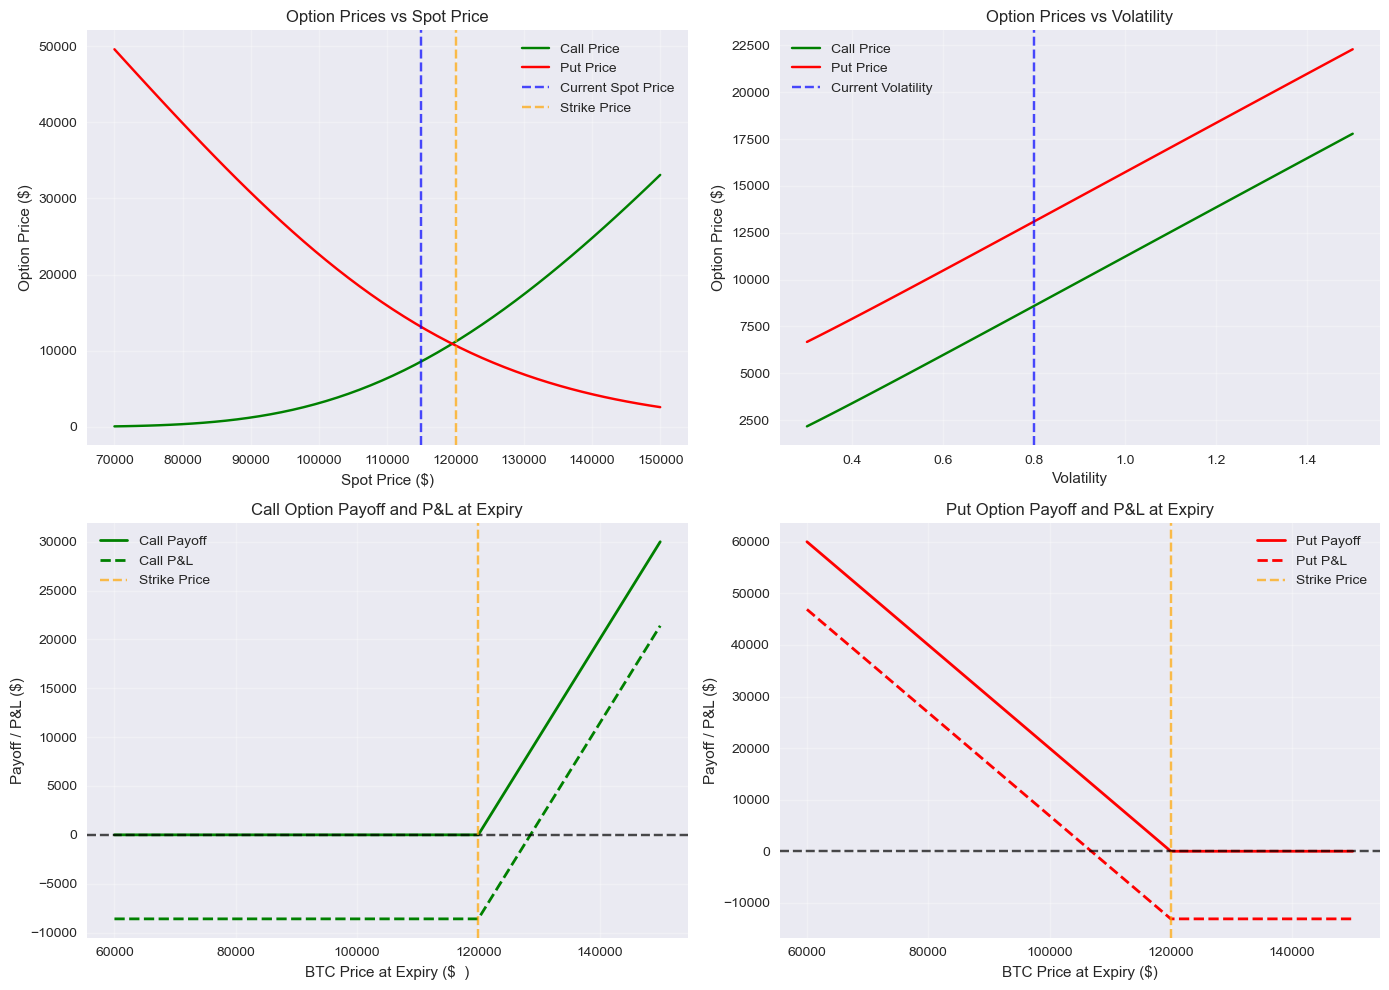

In [4]:
#Visualize option prices change with spot prices and volatilities
spot_range = np.linspace(70000, 150000, 50)
vol_range = np.linspace(0.3, 1.5, 50)

#Price sensitivity to spot price (all else constant)
call_prices_spot = [black_schloes_price(S, strike, time_to_expiry, rf, volatility, option_type='call') for S in spot_range]
put_prices_spot = [black_schloes_price(S, strike, time_to_expiry, rf, volatility, option_type='put') for S in spot_range]

#Price sensitivity to volatility (all else constant)
call_prices_vol = [black_schloes_price(btc_spot, strike, time_to_expiry, rf, vol, option_type='call') for vol in vol_range]
put_prices_vol = [black_schloes_price(btc_spot, strike, time_to_expiry, rf, vol, option_type='put') for vol in vol_range]

#create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
#Plot call and put prices vs spot price
ax1.plot(spot_range, call_prices_spot, label='Call Price', color='green')
ax1.plot(spot_range, put_prices_spot, label='Put Price', color='red')
ax1.axvline(x=btc_spot, color='blue', linestyle='--', alpha=0.7, label='Current Spot Price')
ax1.axvline(x=strike, color='orange', linestyle='--', alpha=0.7, label='Strike Price')
ax1.set_xlabel('Spot Price ($)')
ax1.set_ylabel('Option Price ($)')
ax1.set_title('Option Prices vs Spot Price')
ax1.legend()
ax1.grid(True,alpha=0.3)

#Plot call and put prices vs volatility
ax2.plot(vol_range, call_prices_vol, label='Call Price', color='green')
ax2.plot(vol_range, put_prices_vol, label='Put Price', color='red')
ax2.axvline(x=volatility, color='blue', linestyle='--', alpha=0.7, label='Current Volatility')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Option Price ($)')
ax2.set_title('Option Prices vs Volatility')
ax2.legend()
ax2.grid(True,alpha=0.3)

#Payoff diagrams at expiry
payoff_range = np.linspace(60000, 150000, 100)
call_payoff = [max(0, S - strike) for S in payoff_range]
put_payoff = [max(0, strike - S) for S in payoff_range]
call_pnl = call_payoff - call_price
put_pnl = put_payoff - put_price
ax3.plot(payoff_range, call_payoff, label='Call Payoff', linewidth=2, color='green')
ax3.plot(payoff_range, call_pnl, label='Call P&L', linewidth=2, linestyle='--',color='green')
ax3.axhline(0, color='black', linestyle='--', alpha=0.7)
ax3.axvline(x=strike, color='orange', linestyle='--', alpha=0.7, label='Strike Price')
ax3.set_xlabel('BTC Price at Expiry ($  )')
ax3.set_ylabel('Payoff / P&L ($)')
ax3.set_title('Call Option Payoff and P&L at Expiry')
ax3.legend()
ax3.grid(True,alpha=0.3)

ax4.plot(payoff_range, put_payoff, label='Put Payoff', linewidth=2, color='red')
ax4.plot(payoff_range, put_pnl, label='Put P&L', linewidth=2, linestyle='--',color='red')
ax4.axhline(0, color='black', linestyle='--', alpha=0.7)
ax4.axvline(x=strike, color='orange', linestyle='--', alpha=0.7, label='Strike Price')
ax4.set_xlabel('BTC Price at Expiry ($)')
ax4.set_ylabel('Payoff / P&L ($)')
ax4.set_title('Put Option Payoff and P&L at Expiry')
ax4.legend()
ax4.grid(True,alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
def calulate_greeks(S, K, T, r, sigma, option_type='call'):
    """Calculate the Greeks for European options using Black-Scholes formula.
    option_type: 'call' or 'put'
    Returns a dictionary with Delta, Gamma, Theta, Vega, Rho.
    """
    if T <= 0:
        if option_type == 'call':
            intrinsic_value = max(0, S - K)
            delta = 1.0 if S > K else 0.0
        else:  # put
            intrinsic_value = max(0, K - S)
            delta = -1.0 if S < K else 0.0
        return {
            'price': intrinsic_value,
            'delta': delta,
            'gamma': 0.0,
            'theta': 0.0,
            'vega': 0.0,
            'rho': 0.0
        }
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    n_d1 = norm.pdf(d1)  # for gamma and vega
    # option price
    if option_type == 'call':
        price = S * N_d1 - K * math.exp(-r * T) * N_d2
        delta = N_d1
        rho = K * T * math.exp(-r * T) * N_d2 / 100  # per 1% change in r
    else:
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = N_d1 - 1
        rho = -K * T * math.exp(-r * T) * norm.cdf(-d2) / 100
    # common greeks
    gamma = n_d1 / (S * sigma * math.sqrt(T))
    theta = (- (S * n_d1 * sigma) / (2 * math.sqrt(T)) - r * K * math.exp(-r * T) * N_d2) / 365 if option_type == 'call' else \
            (- (S * n_d1 * sigma) / (2 * math.sqrt(T)) + r * K * math.exp(-r * T) * norm.cdf(-d2)) / 365
    vega = S * n_d1 * math.sqrt(T) / 100  # per 1% change in volatility
    return {
        'price': price,
        'delta': delta,
        'gamma': gamma,
        'theta': theta,
        'vega': vega,
        'rho': rho
    }

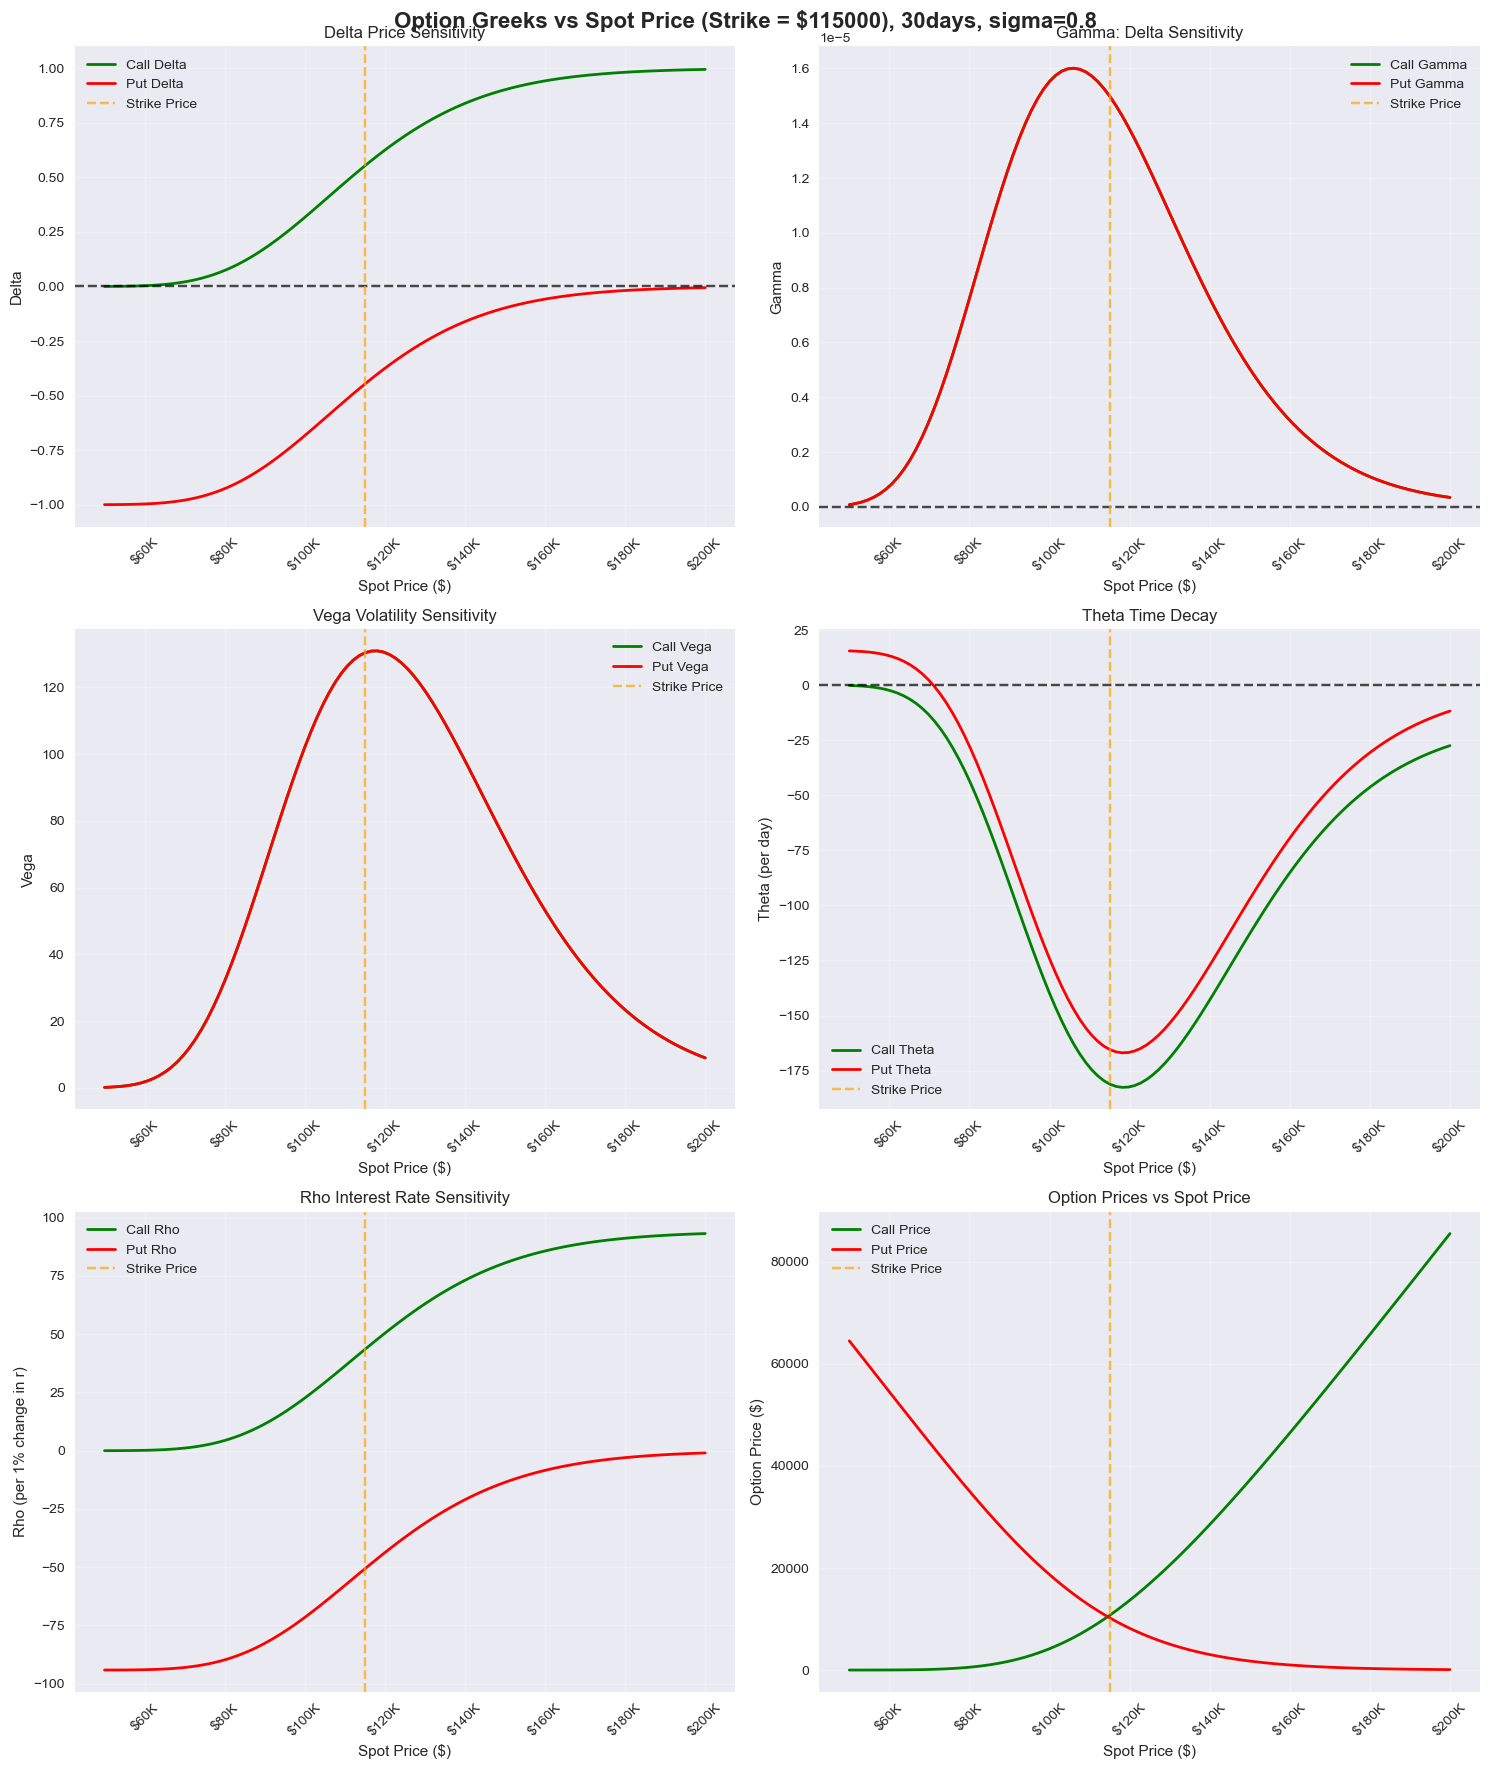

In [6]:
#Visualizing Greeks sensitivity to spot price
K = 115000
T = 30 / 365
r = 0.05
sigma = 0.8
spot_range = np.linspace(50000, 200000, 100)
#iniatialize storage for greeks
call_prices, put_prices = [], []
call_deltas, put_deltas = [], []
call_gammas, put_gammas = [], []
call_thetas, put_thetas = [], []
call_vegas, put_vegas = [], []
call_rhos, put_rhos = [], []

#Calculate greeks across spot price range
for S in spot_range:
    call_greeks = calulate_greeks(S, K, T, r, sigma, option_type='call')
    put_greeks = calulate_greeks(S, K, T, r, sigma, option_type='put')
    
    call_prices.append(call_greeks['price'])
    put_prices.append(put_greeks['price'])
    call_deltas.append(call_greeks['delta'])
    put_deltas.append(put_greeks['delta'])
    call_gammas.append(call_greeks['gamma'])
    put_gammas.append(put_greeks['gamma'])
    call_thetas.append(call_greeks['theta'])
    put_thetas.append(put_greeks['theta'])
    call_vegas.append(call_greeks['vega'])
    put_vegas.append(put_greeks['vega'])
    call_rhos.append(call_greeks['rho'])
    put_rhos.append(put_greeks['rho'])

#Create subplots for greeks
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle(f'Option Greeks vs Spot Price (Strike = ${K}), 30days, sigma={sigma}', fontsize=16, fontweight='bold')

#Plot Delta
axes[0, 0].plot(spot_range, call_deltas, 'b-',linewidth=2, label='Call Delta', color='green')
axes[0, 0].plot(spot_range, put_deltas, 'r-',linewidth=2, label='Put Delta', color='red')
axes[0, 0].axhline(0, color='black', linestyle='--', alpha=0.7)
axes[0, 0].axvline(x=K, color='orange', linestyle='--', alpha=0.7, label='Strike Price')
axes[0, 0].set_xlabel('Spot Price ($)')
axes[0, 0].set_ylabel('Delta')
axes[0, 0].set_title('Delta Price Sensitivity')
axes[0, 0].legend()
axes[0, 0].grid(True,alpha=0.3)
axes[0,0].set_ylim([-1.1,1.1])

#Plot Gamma
axes[0, 1].plot(spot_range, call_gammas, 'b-',linewidth=2, label='Call Gamma', color='green')
axes[0, 1].plot(spot_range, put_gammas, 'r-',linewidth=2, label='Put Gamma', color='red')
axes[0, 1].axhline(0, color='black', linestyle='--', alpha=0.7)
axes[0, 1].axvline(x=K, color='orange', linestyle='--', alpha=0.7, label='Strike Price')
axes[0, 1].set_xlabel('Spot Price ($)')
axes[0, 1].set_ylabel('Gamma')
axes[0, 1].set_title('Gamma: Delta Sensitivity')
axes[0, 1].legend()
axes[0, 1].grid(True,alpha=0.3)

#Vega
axes[1, 0].plot(spot_range, call_vegas, 'b-',linewidth=2, label='Call Vega', color='green')
axes[1, 0].plot(spot_range, put_vegas, 'r-',linewidth=2, label='Put Vega', color='red')
axes[1, 0].axvline(x=K, color='orange', linestyle='--', alpha=0.7, label='Strike Price')
axes[1, 0].set_xlabel('Spot Price ($)')
axes[1, 0].set_ylabel('Vega')
axes[1, 0].set_title('Vega Volatility Sensitivity')
axes[1, 0].legend()
axes[1, 0].grid(True,alpha=0.3)

#Theta
axes[1, 1].plot(spot_range, call_thetas, 'b-',linewidth=2, label='Call Theta', color='green')
axes[1, 1].plot(spot_range, put_thetas, 'r-',linewidth=2, label='Put Theta', color='red')
axes[1, 1].axhline(0, color='black', linestyle='--', alpha=0.7) 
axes[1, 1].axvline(x=K, color='orange', linestyle='--', alpha=0.7, label='Strike Price')
axes[1, 1].set_xlabel('Spot Price ($)')
axes[1, 1].set_ylabel('Theta (per day)')
axes[1, 1].set_title('Theta Time Decay')
axes[1, 1].legend()
axes[1, 1].grid(True,alpha=0.3)

#Rho
axes[2, 0].plot(spot_range, call_rhos, 'b-',linewidth=2, label='Call Rho', color='green')
axes[2, 0].plot(spot_range, put_rhos, 'r-',linewidth=2, label='Put Rho', color='red')
axes[2, 0].axvline(x=K, color='orange', linestyle='--', alpha=0.7, label='Strike Price')            
axes[2, 0].set_xlabel('Spot Price ($)')
axes[2, 0].set_ylabel('Rho (per 1% change in r)')
axes[2, 0].set_title('Rho Interest Rate Sensitivity')
axes[2, 0].legend()
axes[2, 0].grid(True,alpha=0.3)

#Option Price for reference
axes[2, 1].plot(spot_range, call_prices, 'b-',linewidth=2, label='Call Price', color='green')
axes[2, 1].plot(spot_range, put_prices, 'r-',linewidth=2, label='Put Price', color='red')
axes[2, 1].axvline(x=K, color='orange', linestyle='--', alpha=0.7, label='Strike Price')            
axes[2, 1].set_xlabel('Spot Price ($)')
axes[2, 1].set_ylabel('Option Price ($)')
axes[2, 1].set_title('Option Prices vs Spot Price')
axes[2, 1].legend()
axes[2, 1].grid(True,alpha=0.3)

#format x-axis for all subplots
for ax in axes.flat:    
    ax.xaxis.set_major_formatter('${x:,.0f}')
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

In [7]:
#Time Decay Risk
print("Time Decay Risk Analysis:")
btc_price = 115000
strike = 120000
days_left = 30
vol = 0.8
r = 0.05
print(f'Initial Position : Long 1 BTC ${strike} Call')
print(f"BTC Price ${btc_price}Days to Expiry: {days_left}, Volatility: {vol}, Risk-free rate: {r}")
time_points = [30, 25, 20, 15, 10, 7, 5, 3, 1, 0]
options_value = []
print(f"{'Days Left':<10}{'Option Value':<12}{'Daily Decay':<12}{'% Decay':<10}")
print("-" * 50)
previous_value = None
for days in time_points:
    T = days / 365
    if T >0:
        value = black_schloes_price(btc_price, strike, T, r, vol, option_type='call')
    else:
        value = max(0, btc_price - strike)  # intrinsic value at expiry

    options_value.append(value)
    if previous_value is not None:
        daily_decay = previous_value - value
        time_diff = previous_days - days if previous_days != days else 1
        daily_decay = daily_decay / max(time_diff,1)
        pct_decay = (daily_decay / previous_value) * 100 if previous_value != 0 else 0
        print(f"{days:<10}{value:<11.0f}{daily_decay:<11.0f}{pct_decay:<9.1f}")
    else:
        print(f"{days:<10}{value:<11.0f}{'-':<12}{'-':<10}")

    previous_value = value
    previous_days = days

total_decay = options_value[0] - options_value[-1]
print("-" * 50)
print(f"Total Decay over {time_points[0]} days: ${total_decay:.2f}")
print(f"Average Daily Decay: ${total_decay / options_value[0]*100:.1f}% of premium")
print("=" * 50)


Time Decay Risk Analysis:
Initial Position : Long 1 BTC $120000 Call
BTC Price $115000Days to Expiry: 30, Volatility: 0.8, Risk-free rate: 0.05
Days Left Option ValueDaily Decay % Decay   
--------------------------------------------------
30        8601       -           -         
25        7654       189        2.2      
20        6614       208        2.7      
15        5444       234        3.5      
10        4077       273        5.0      
7         3107       324        7.9      
5         2358       374        12.0     
3         1481       439        18.6     
1         400        541        36.5     
0         0          400        100.0    
--------------------------------------------------
Total Decay over 30 days: $8600.57
Average Daily Decay: $100.0% of premium


In [8]:
#Volatility Risk
print("Volatility Risk Analysis:")
print('=' * 50)
#same position as above
T=30 / 365
r=0.05
print(f'Initial Position : Long 1 BTC ${strike} Call')
print(f"BTC Price ${btc_price}, Days to Expiry: 30, Risk-free rate: {r}")
vol_scenarios = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
print(f"{'Volatility':<12}{'Option Value':<15}{'P&L':<15}{'% Change':<10}")
print("-" * 50)
base_vol = 0.8
base_value = black_schloes_price(btc_price, strike, T, r, base_vol, option_type='call')
for vol in vol_scenarios:
    value = black_schloes_price(btc_price, strike, T, r, vol, option_type='call')
    pnl = value - base_value
    pct_change = (pnl / base_value) * 100 if base_value != 0 else 0
    marker = "<-base" if vol == base_vol else ""
    print(f"{vol:<12.2f}{value:<14.2f}{pnl:<14.2f}{pct_change:<9.1f}% {marker}")



Volatility Risk Analysis:
Initial Position : Long 1 BTC $120000 Call
BTC Price $115000, Days to Expiry: 30, Risk-free rate: 0.05
Volatility  Option Value   P&L            % Change  
--------------------------------------------------
0.40        3405.61       -5194.96      -60.4    % 
0.60        5982.00       -2618.57      -30.4    % 
0.80        8600.57       0.00          0.0      % <-base
1.00        11230.17      2629.60       30.6     % 
1.20        13858.82      5258.25       61.1     % 
1.40        16480.15      7879.58       91.6     % 


In [9]:
#Gamma Risk
print("Gamma Risk Analysis:")
print('=' * 50)
#same position as above
btc_current = 115000
strike_atm =115000
T = 30 / 365
r = 0.05
vol = 0.8
position_size = -10  # short 10 contracts
print(f'Initial Position : Short {abs(position_size)} BTC ${strike_atm} Call')
print(f"BTC Price ${btc_current}, Days to Expiry: 30, Volatility: {vol}, Risk-free rate: {r}")
#initial greesk
initial_greeks = calulate_greeks(btc_current, strike_atm, T, r, vol, option_type='call')
print(f"Initial Gamma: {initial_greeks['gamma']:.6f}")
print("initial Delta:", initial_greeks['delta'])
print(f"{'BTC Price':<12}{'Delta/ Contract':<18}{'Total Delta':<12}{'P&L ':<22}{'Gamma Effect':<15}")
print("-" * 80)
btc_scenarios = [105000, 110000, 115000, 120000, 125000, 130000]
base_price = initial_greeks['price']
for price in btc_scenarios:
    greeks = calulate_greeks(price, strike_atm, T, r, vol, option_type='call')
    price_change = greeks['price'] - base_price
    total_pnl = price_change * position_size
    total_delta = greeks['delta'] * position_size
    delta_change = greeks['delta'] - initial_greeks['delta'] 
    gamma_effect = position_size * delta_change
    marker = "<-current" if price == btc_current else ""
    print(f"{price:<12}{greeks['delta']:<17.6f}{total_delta:<12.6f}{total_pnl:<21.2f}{gamma_effect:<15.2f}{marker}")
    

Gamma Risk Analysis:
Initial Position : Short 10 BTC $115000 Call
BTC Price $115000, Days to Expiry: 30, Volatility: 0.8, Risk-free rate: 0.05
Initial Gamma: 0.000015
initial Delta: 0.5527430097901219
BTC Price   Delta/ Contract   Total Delta P&L                   Gamma Effect   
--------------------------------------------------------------------------------
105000      0.395870         -3.958704   47515.99             1.57           
110000      0.475592         -4.755923   25724.90             0.77           
115000      0.552743         -5.527430   -0.00                -0.00          <-current
120000      0.624818         -6.248177   -29464.35            -0.72          
125000      0.690104         -6.901044   -62368.20            -1.37          
130000      0.747663         -7.476626   -98345.61            -1.95          


In [10]:
# Portfolio setup for scenario analysis
base_spot = 115000
base_vol = 0.8
days_to_expiry = 30  # calendar days remaining
r = 0.05

# Each position can carry a contract_size multiplier (e.g., 1 BTC per contract)
positions = [
    {"name": "Long 1x $120K Call", "type": "call", "strike": 120000, "contracts": 1, "contract_size": 1},
]

def evaluate_portfolio(spot, vol, days_forward=0):
    """Aggregate value and Greeks for the configured portfolio."""
    T_effective = max((days_to_expiry - days_forward) / 365, 0.0001)
    totals = {"value": 0.0, "delta": 0.0, "gamma": 0.0, "theta": 0.0, "vega": 0.0, "rho": 0.0}
    for pos in positions:
        scale = pos.get("contract_size", 1) * pos.get("contracts", 1)
        greeks = calulate_greeks(spot, pos['strike'], T_effective, r, vol, option_type=pos['type'])
        totals['value'] += greeks['price'] * scale
        totals['delta'] += greeks['delta'] * scale
        totals['gamma'] += greeks['gamma'] * scale
        totals['theta'] += greeks['theta'] * scale
        totals['vega']  += greeks['vega'] * scale
        totals['rho']   += greeks['rho'] * scale
    return T_effective, totals

# fresh base snapshot each time the cell is run
base_T, base_portfolio = evaluate_portfolio(base_spot, base_vol)
print("Base portfolio snapshot:")
print(f"Spot=${base_spot:,.0f}, Vol={base_vol}, Days to expiry={days_to_expiry}, Value=${base_portfolio['value']:.2f}")
print(f"Delta={base_portfolio['delta']:.4f}, Vega={base_portfolio['vega']:.4f}, Theta/day={base_portfolio['theta']:.4f}")


Base portfolio snapshot:
Spot=$115,000, Vol=0.8, Days to expiry=30, Value=$8600.57
Delta=0.4789, Vega=131.3448, Theta/day=-181.4922


In [11]:
#Scenario Analysis (full revaluation + Greek attribution)
# recompute base in case upstream values changed
_, base_portfolio = evaluate_portfolio(base_spot, base_vol, days_forward=0)
print(f"{'Scenario':<25}{'BTC Price':<12}{'Vol':<8}{'Days Fwd':<10}{'Reval P&L':<14}{'Delta P&L':<14}{'Vega P&L':<14}{'Theta P&L':<14}{'Residual':<12}{'Value ($)':<12}")
print("-" * 135)

scenarios = [
    {"name":"Base Case","btc":base_spot, "vol":base_vol, "days":0},
    {"name":"BTC +10%, Vol Unchanged", "btc":126500, "vol":0.8, "days":1},
    {"name": "BTC +10%, Vol +20%", "btc":126500, "vol":0.96, "days":1},
    {"name": "BTC sideways, Vol -25%","btc": 115000, "vol":0.6, "days":7},
    {"name":"Crash -20%, Vol +50%", "btc":92000, "vol":1.2, "days":1},
]

base_value = base_portfolio['value']
for scenario in scenarios:
    _, scenario_portfolio = evaluate_portfolio(scenario['btc'], scenario['vol'], days_forward=scenario['days'])
    reval_pnl = scenario_portfolio['value'] - base_value  # full revaluation P&L
    delta_pnl = base_portfolio['delta'] * (scenario['btc'] - base_spot)
    vega_pnl = base_portfolio['vega'] * (scenario['vol'] - base_vol) * 100
    theta_pnl = base_portfolio['theta'] * scenario['days']
    residual = reval_pnl - (delta_pnl + vega_pnl + theta_pnl)  # gamma/vanna/rho and higher order effects

    if scenario['name'] == "Base Case":
        print(f"{scenario['name']:<25}{scenario['btc']:<12}{scenario['vol']:<8}{scenario['days']:<10}{'-':<14}{'-':<14}{'-':<14}{'-':<14}{'-':<12}{scenario_portfolio['value']:<12.2f}")
    else:
        print(f"{scenario['name']:<25}{scenario['btc']:<12}{scenario['vol']:<8}{scenario['days']:<10}{reval_pnl:<14.2f}{delta_pnl:<14.2f}{vega_pnl:<14.2f}{theta_pnl:<14.2f}{residual:<12.2f}{scenario_portfolio['value']:<12.2f}")


Scenario                 BTC Price   Vol     Days Fwd  Reval P&L     Delta P&L     Vega P&L      Theta P&L     Residual    Value ($)   
---------------------------------------------------------------------------------------------------------------------------------------
Base Case                115000      0.8     0         -             -             -             -             -           8600.57     
BTC +10%, Vol Unchanged  126500      0.8     1         6276.12       5507.10       0.00          -181.49       950.51      14876.69    
BTC +10%, Vol +20%       126500      0.96    1         8414.36       5507.10       2101.52       -181.49       987.24      17014.93    
BTC sideways, Vol -25%   115000      0.6     7         -3630.42      0.00          -2626.90      -1270.45      266.92      4970.15     
Crash -20%, Vol +50%     92000       1.2     1         -4173.41      -11014.20     5253.79       -181.49       1768.49     4427.16     
